# Book recommedation system using Wikipedia articles

## Prerequisites

Before we begin, ensure you have the requirements fulfilled.
Ensure you have the following librairies installed in your anaconda:
1. BeautifulSoup
2. requests
3. Tensorflow
4. bz2
5. xml.sax
6. mwparserfromhell
7. multiprocessing
8. Keras

In the root directory, you will find a python file by the name "Parsing wikipedia pages.py". Open the py file in any python IDE and edit the file path in line number 48 to the file path of your directory. This is a must!!

To ensure that all the bz files are downloaded to the path ~/Data/wiki and the JSON partitions are extracted to ~/Data/wiki/partitions, you must have these directories created before you run the py file

Run the "Parsing wikipedia pages.py" file to download all Wikipedia articles we need and extract the partition in JSON format

### Citation

1. [Parsing wiki articles](https://towardsdatascience.com/wikipedia-data-science-working-with-the-worlds-largest-encyclopedia-c08efbac5f5c)
2. [Recommendation system for wiki articles](https://towardsdatascience.com/building-a-recommendation-system-using-neural-network-embeddings-1ef92e5c80c9)

## WordtoVec embedding

Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. Consider the following similar sentences: Have a good day and Have a great day. They hardly have different meaning. If we construct an exhaustive vocabulary (let’s call it V), it would have V = {Have, a, good, great, day}.

Now, let us create a one-hot encoded vector for each of these words in V. Length of our one-hot encoded vector would be equal to the size of V (=5). We would have a vector of zeros except for the element at the index representing the corresponding word in the vocabulary. That particular element would be one. The encodings below would explain this better.

Have = [1,0,0,0,0]; a=[0,1,0,0,0] ; good=[0,0,1,0,0] ; great=[0,0,0,1,0] ; day=[0,0,0,0,1]

If we try to visualize these encodings, we can think of a 5 dimensional space, where each word occupies one of the dimensions and has nothing to do with the rest (no projection along the other dimensions). This means ‘good’ and ‘great’ are as different as ‘day’ and ‘have’, which is not true.

Our objective is to have words with similar context occupy close spatial positions. Mathematically, the cosine of the angle between such vectors should be close to 1, i.e. angle close to 0.

[Word2Vec](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa)

Word2Vec is a method to construct such an embedding. In this project, We will be using Neural network embedding to recommend similar books based on the query book we provide. We will use cosine similarity to determine which book is most similar to the query book.

## Neural Network Embedding

The basic idea behind entity embeddings is to convert high dimensional categorical data into low dimensional vectors so that we place similar entities close to one another. As we saw, One-hot encoding does not seem like a viable option to achieve our goal. By training a neural network to learn entity embeddings, we not only get a reduced dimension representation of the books, we also get a representation that keeps similar books closer to each other. Therefore, the basic approach for a recommendation system is to create entity embeddings of all the books, and then for any book, find the closest other books in the embedding space.

To create these entity embedding, we will build a Neural network Emdedding and train it on a supervised machine learning task that results in similar books having closer representations in the embedding space. The parameters which are the weights of the neural networks are adjusted during training to reduce the loss of the model.

Once we have the embeddings for the books and the links, we can find the most similar book to a given book by computing the distance between the embedded vector for that book and all the other book embeddings. We'll use the cosine distance which measures the angle between two vectors as a measure of similarity

### Evaluation

To evaluate the recommendations, we will use cosine similarity to measure the entities closest to the query entity. Mathematically, the cosine of the angle between such vectors should be close to 1, i.e. angle close to 0.

![cosineSimilarity](images/download.jpeg)

Therefore, to compute similarity, we take a query book and find the dot product between its vector and those of all the other books. If our embeddings are normalized, this dot product is the cosine distance between vectors that ranges from -1, most dissimilar, to +1, most similar.

This code was adapted form the following tutorials:

[Building a Recommendation System Using Neural Network Embeddings](https://towardsdatascience.com/building-a-recommendation-system-using-neural-network-embeddings-1ef92e5c80c9)

[Parsing wikipedia articles](https://towardsdatascience.com/wikipedia-data-science-working-with-the-worlds-largest-encyclopedia-c08efbac5f5c)

![embed.jpeg](images/embed.jpeg)

## Imports

In [2]:
from IPython.core.interactiveshell import InteractiveShell

# Set shell to show all lines of output
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
import json
from multiprocessing.dummy import Pool as Threadpool
from itertools import chain
from timeit import default_timer as timer
import os
from itertools import chain
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
import random
from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
import umap
random.seed(100)


### Multithreading

Since we have 55 partitions on JSON files, we use multithreading to parse through all the partitions to generate a single JSON file containing all the articles. These are specifically book articles which we previously extracted. We can extend the scope of this project to all of the wikipedia articles.

In [3]:
def read_data(file_path):
    """Read in json data from `file_path`"""
    
    data = []
    
    # Open the file and load in json
    with open(file_path, 'r') as fin:
        for l in fin.readlines():
            data.append(json.loads(l))
            
    return data

In [4]:
start = timer()

# List of files to read in
saved_files = ['Data/wiki/partitions/' + x for x in os.listdir('Data/wiki/partitions/')]

# Create a threadpool for reading in files
threadpool = Threadpool(processes = 10)

# Read in the files as a list of lists
results = threadpool.map(read_data, saved_files)

# Flatten the list of lists to a single list
book_list = list(chain(*results))

end = timer()

print(f'Found {len(book_list)} books in {round(end - start)} seconds.')

Found 37040 books in 1 seconds.


In [ ]:
if not os.path.exists(os.getcwd() + 'Data/found_books_filtered.json'):
    with open('Data/found_books_filtered.json', 'wt') as fout:
        for book in book_list:
             fout.write(json.dumps(book) + '\n')
    print('Books saved.')
else:
    print('Files already saved.')

## Data Preprocesing

We want to retrieve all the books into a single list. We will use that list to preprocess the data to generate a training input file. We find that there are about 37000 books in our input. We want to extract two things from each element of the list: the title of the book and the wikilinks provided in the articles. We do this because the title and the links contained in them are sufficient information required to create an entity embedding for the articles

In [6]:
books = []

with open('Data/found_books_filtered.json', 'r') as fin:
    # Append each line to the books
    books = [json.loads(l) for l in fin]

In [7]:
# Remove non-book articles
books_with_wikipedia = [book for book in books if 'Wikipedia:' in book[0]]
books = [book for book in books if 'Wikipedia:' not in book[0]]
print(f'Found {len(books)} books.')

Found 37020 books.


Each legitimate book contains the title, the information from the Infobox book template, the internal wikipedia links, the external links, the date of last edit, and the number of characters in the article. The links are present in the [n][2] element of the article list. The title is the 0th element of the list.

In [10]:
n = 20
books[n][0], books[n][1], books[n][2][:5], books[n][3][:5], books[n][3][:5], books[n][4], books[n][5]

('Don Quixote',
 {'name': 'Don Quixote',
  'image': 'El ingenioso hidalgo don Quijote de la Mancha.jpg',
  'image_size': '250px',
  'caption': 'Title page of first edition (1605)',
  'author': 'Miguel de Cervantes',
  'country': 'Spain',
  'language': 'Early Modern Spanish',
  'genre': 'Novel',
  'publisher': 'Francisco de Robles',
  'pub_date': '1605 (Part One) < br > 1615 (Part Two)',
  'english_pub_date': '1612 (Part One) < br > 1620 (Part Two)',
  'media_type': 'Print',
  'dewey': '863',
  'congress': 'PQ6323'},
 ['Miguel de Cervantes',
  'Early Modern Spanish',
  'Novel',
  'Francisco de Robles',
  'novel'],
 ['https://www.oxforddictionaries.com/definition/english/don-quixote',
  'https://www.theguardian.com/world/2002/may/08/humanities.books',
  'http://www.gutenberg.org/cache/epub/10714/pg10714.html',
  'https://archive.is/20150504103459/http://www.gutenberg.org/cache/epub/10714/pg10714.html',
  'https://www.theguardian.com/books/2003/dec/13/classics.miguelcervantes'],
 ['https:

First we want to create a mapping of book titles to integers. When we feed books into the embedding neural network, we will have to represent them as numbers, and this mapping will let us keep track of the books. We'll also create the reverse mapping, from integers back to the title.

In [12]:
book_index = {book[0]: idx for idx, book in enumerate(books)}
index_book = {idx: book for book, idx in book_index.items()}

book_index['Anna Karenina']
index_book[34983]

34983

'Anna Karenina'

The function below takes an input list and returns a sorted ordered dictionary of the counts of items in the list. We will be using the collections module to perform this operation

In [18]:
def count_items(l):
    """Return ordered dictionary of counts of objects in `l`"""
    
    # Create a counter object
    counts = Counter(l)
    
    # Sort by highest count first and place in ordered dictionary
    counts = sorted(counts.items(), key = lambda x: x[1], reverse = True)
    counts = OrderedDict(counts)
    
    return counts

We only want to count wikilinks from each book once, so we first find the set of links for each book, then we flatten the list of lists to a single list, and finally pass it to the count_items function.

In [20]:
# Find set of wikilinks for each book and convert to a flattened list
unique_wikilinks = list(chain(*[list(set(book[2])) for book in books]))

wikilink_counts = count_items(unique_wikilinks)
list(wikilink_counts.items())[:10]

[('Hardcover', 7489),
 ('Paperback', 7311),
 ('Wikipedia:WikiProject Books', 6043),
 ('Wikipedia:WikiProject Novels', 6015),
 ('English language', 4185),
 ('United States', 3060),
 ('Science fiction', 3030),
 ('The New York Times', 2727),
 ('science fiction', 2502),
 ('novel', 1979)]

Since there are some discerpencies due to capitalizing of certain links, we will convert every link to lower case and redo the counts

In [21]:
wikilinks = [link.lower() for link in unique_wikilinks]
print(f"There are {len(set(wikilinks))} unique wikilinks.")

wikilink_counts = count_items(wikilinks)
list(wikilink_counts.items())[:10]

There are 297624 unique wikilinks.


[('paperback', 8740),
 ('hardcover', 8648),
 ('wikipedia:wikiproject books', 6043),
 ('wikipedia:wikiproject novels', 6016),
 ('science fiction', 5665),
 ('english language', 4248),
 ('united states', 3063),
 ('novel', 2983),
 ('the new york times', 2742),
 ('fantasy', 2003)]

Let us remove the most popular links like "paperback", "hardcover", etc since this information is clearly not necessary to create embedding. Infact, having these terms as input might result in poor recommendations

In [22]:
to_remove = ['hardcover', 'paperback', 'hardback', 'e-book', 'wikipedia:wikiproject books', 'wikipedia:wikiproject novels']
for t in to_remove:
    wikilinks.remove(t)
    _ = wikilink_counts.pop(t)

In [23]:
# Limit to greater than 3 links
links = [t[0] for t in wikilink_counts.items() if t[1] >= 4]
print(len(links))

41758


As a final bit of exploration, let's look at the books that are mentioned the most by other books on Wikipedia. We'll take the set of links for each book so that we don't have multiple counts for books that are linked to by another book more than once.

In [24]:
# Find set of book wikilinks for each book
unique_wikilinks_books = list(chain(*[list(set(link for link in book[2] if link in book_index.keys())) for book in books]))

# Count the number of books linked to by other books
wikilink_book_counts = count_items(unique_wikilinks_books)
list(wikilink_book_counts.items())[:10]

[('The Encyclopedia of Science Fiction', 127),
 ('The Discontinuity Guide', 104),
 ('The Encyclopedia of Fantasy', 63),
 ('Dracula', 55),
 ('Nineteen Eighty-Four', 51),
 ('Encyclopædia Britannica', 51),
 ('The Wonderful Wizard of Oz', 49),
 ('Don Quixote', 49),
 ("Alice's Adventures in Wonderland", 47),
 ('Brave New World', 39)]

Create a mapping of links the same way we did for book titles.

In [28]:
link_index = {link: idx for idx, link in enumerate(links)}
index_link = {idx: link for link, idx in link_index.items()}

link_index['the economist']
index_link[300]
print(f'There are {len(link_index)} wikilinks that will be used.')

300

'the economist'

There are 41758 wikilinks that will be used.


The next step is to create pairs of book index and the link index. Here, we create tuples of book index and all the corresponding link indexes. So, if book_index 40 has the link indexes 1,2 and 3 in it, we will create 3 tuples for book 40 which are (40,1),(40,2) and (40,3). The final pairs list will consist of tuples of every (book, link) pairing on all of Wikipedia. This will be used to create a training set

In [30]:
pairs = []

# Iterate through each book
for book in books:
    # Iterate through the links in the book
    pairs.extend((book_index[book[0]], link_index[link.lower()]) for link in book[2] if link.lower() in links)
    
len(pairs), len(links), len(books)

(772798, 41758, 37020)

In [32]:
pairs[5001]

(73, 16094)

In [34]:
index_book[pairs[5001][0]], index_link[pairs[5001][1]]

('Sir Gawain and the Green Knight', 'ruby')

In [35]:
pairs_set = set(pairs)

Now that we have the pairs of books and links, we may use this to create our training data. They are the numerical representations of the books and the links by their index. 

## Generating Training data

To compute the embeddings, we will not be creating a training and validation set for our data. Instead, we will be using the entire dataset to train the samples. We do this because we are not interested in predicting anything new, but we are more interesting in creating an embedding space for each of the books which would help us finding the books similar to one another. 

The function below generates a batch of inputs to train at every increment. We need to generate positive samples and negative samples to train the neural network. The positive samples are simple: pick a pair from pairs and assign it a 1. The negative samples are also fairly easy: pick one random link and one random book, make sure they are not in pairs, and assign them a -1 or a 0. (We'll use either a -1 or 0 for the negative labels depending on whether we want to make this a regression or a classification problem. Either approach is valid, and we'll try out both methods.)

In [39]:
def generate_batch(pairs, n_positive = 50, negative_ratio = 1.0, classification = False):
    """Generate batches of samples for training"""
    batch_size = n_positive * (1 + negative_ratio)
    batch = np.zeros((batch_size, 3))
    
    # Adjust label based on task
    if classification:
        neg_label = 0
    else:
        neg_label = -1
    
    # This creates a generator
    while True:
        # randomly choose positive examples
        for idx, (book_id, link_id) in enumerate(random.sample(pairs, n_positive)):
            batch[idx, :] = (book_id, link_id, 1)

        # Increment idx by 1
        idx += 1
        
        # Add negative examples until reach batch size
        while idx < batch_size:
            
            # random selection
            random_book = random.randrange(len(books))
            random_link = random.randrange(len(links))
            
            # Check to make sure this is not a positive example
            if (random_book, random_link) not in pairs_set:
                
                # Add to batch and increment index
                batch[idx, :] = (random_book, random_link, neg_label)
                idx += 1
                
        # Make sure to shuffle order
        np.random.shuffle(batch)
        yield {'book': batch[:, 0], 'link': batch[:, 1]}, batch[:, 2]

Since Neural networks train data in increments, at each increment, we feed a new sample to the model by generating a new batch as shown below.

In [40]:
next(generate_batch(pairs, n_positive = 2, negative_ratio = 2))

({'book': array([22359., 28410., 29814., 25757.,  6860.,  7206.]),
  'link': array([  539., 33217., 11452., 22920.,  7387., 34924.])},
 array([ 1., -1., -1., -1.,  1., -1.]))

In [41]:
x, y = next(generate_batch(pairs, n_positive = 2, negative_ratio = 2))

# Show a few example training pairs
for label, b_idx, l_idx in zip(y, x['book'], x['link']):
    print(f'Book: {index_book[b_idx]:30} Link: {index_link[l_idx]:40} Label: {label}')

Book: German Lottery                 Link: ammonia                                  Label: -1.0
Book: Who Wrote The Dead Sea Scrolls? Link: dunkirk                                  Label: -1.0
Book: The Power of the Daleks        Link: david whitaker (screenwriter)            Label: 1.0
Book: The Comforts of Madness (novel) Link: epub                                     Label: -1.0
Book: Beyond a Boundary              Link: aurum press                              Label: 1.0
Book: The Secret History of Twin Peaks Link: southern england                         Label: -1.0


The next step is the most important. We are going to construct a neural network that learns entity embeddings. The steps can be easily explained with the block diagram shown below:

![block.jpeg](images/block.jpeg)

The inputs are given parallely to the embedding layer. The embedding layer creates a 50 dimensional vector for both book and link embedding. This is done for each of the 37000 books in the article set.
Using these vectors, we find the dot product of the book and link vectors. The variable merged computes the dot product of the articles.  
This dot product gives the cosine similarity between the books and links.

For regression, we will be using mean squared error as the loss function and Adam as the optimizer.

In [43]:
def book_embedding_model(embedding_size = 50, classification = False):
    """Model to embed books and wikilinks using the functional API.
       Trained to discern if a link is present in a article"""
    
    # Both inputs are 1-dimensional
    book = Input(name = 'book', shape = [1])
    link = Input(name = 'link', shape = [1])
    
    # Embedding the book (shape will be (None, 1, 50))
    book_embedding = Embedding(name = 'book_embedding',
                               input_dim = len(book_index),
                               output_dim = embedding_size)(book)
    
    # Embedding the link (shape will be (None, 1, 50))
    link_embedding = Embedding(name = 'link_embedding',
                               input_dim = len(link_index),
                               output_dim = embedding_size)(link)
    
    # Merge the layers with a dot product along the second axis (shape will be (None, 1, 1))
    merged = Dot(name = 'dot_product', normalize = True, axes = 2)([book_embedding, link_embedding])
    
    # Reshape to be a single number (shape will be (None, 1))
    merged = Reshape(target_shape = [1])(merged)
    
    # If classifcation, add extra layer and loss function is binary cross entropy
    if classification:
        merged = Dense(1, activation = 'sigmoid')(merged)
        model = Model(inputs = [book, link], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # Otherwise loss function is mean squared error
    else:
        model = Model(inputs = [book, link], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'mse')
    
    return model

# Instantiate model and show parameters
model = book_embedding_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
book (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
link (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
book_embedding (Embedding)      (None, 1, 50)        1851000     book[0][0]                       
__________________________________________________________________________________________________
link_embedding (Embedding)      (None, 1, 50)        2087900     link[0][0]                       
__________________________________________________________________________________________________
dot_produc

## Recomendation using Regression

In this method, we use mean squared error as our loss function. We find the cosine similarity using regression to embed each vector in the embedding space. Regression is used to predict the label of the book and the corresponding link (1 or -1).
As the loss function decreases, we find that the words are being correctly embedded into the embedding space.

We can play around with the parameters to see if we would get better results.

We train the model for 50 epochs. As we can see, the loss function decreases as the epoch number increases.

In [44]:
n_positive = 1024

gen = generate_batch(pairs, n_positive, negative_ratio = 2)

# Train
h = model.fit_generator(gen, epochs = 50, 
                        steps_per_epoch = len(pairs) // n_positive,
                        verbose = 1)

Epoch 1/50
754/754 [==============================] - 70s 93ms/step - loss: 0.9772
Epoch 2/50
754/754 [==============================] - 66s 88ms/step - loss: 0.8611
Epoch 3/50
754/754 [==============================] - 61s 81ms/step - loss: 0.6895
Epoch 4/50
754/754 [==============================] - 60s 80ms/step - loss: 0.6260
Epoch 5/50
754/754 [==============================] - 59s 78ms/step - loss: 0.6136
Epoch 6/50
754/754 [==============================] - 58s 77ms/step - loss: 0.6525
Epoch 7/50
754/754 [==============================] - 60s 80ms/step - loss: 0.5826
Epoch 8/50
754/754 [==============================] - 61s 80ms/step - loss: 0.5829
Epoch 9/50
754/754 [==============================] - 60s 80ms/step - loss: 0.5734
Epoch 10/50
754/754 [==============================] - 60s 80ms/step - loss: 0.5659
Epoch 11/50
754/754 [==============================] - 60s 80ms/step - loss: 0.5664
Epoch 12/50
754/754 [==============================] - 60s 80ms/step - loss: 0.5589
E

Save the model

In [45]:
model.save('regression_embedding.h5')

## Find similar Books

The trained model has learned representations of books and wikilinks that place similar entities close to one another in the embedding space. To find out if this is the case, we extract the embeddings and use them to find similar books and links.
These weights are vector representations of each of the books.

In [46]:
# Extract embeddings
book_layer = model.get_layer('book_embedding')
book_weights = book_layer.get_weights()[0]
book_weights.shape

(37020, 50)

Observe how the weights are distributed in the for book in index 0

In [49]:
book_weights = book_weights / np.linalg.norm(book_weights, axis = 1).reshape((-1, 1))
book_weights[0][:10]
np.sum(np.square(book_weights[0]))

array([ 0.19503373, -0.07946133, -0.20975773, -0.03732468, -0.05901643,
        0.08038721,  0.0689129 , -0.02692453, -0.18320043, -0.16246662],
      dtype=float32)

1.0

#### Now let us find the recommendations based on the query book. We do that using the function find_similar explained below.

#### The function below takes in either a book or a link, a set of embeddings, and returns the n most similar items to the query. It does this by computing the dot product between the query and embeddings. Because we normalized the embeddings, the dot product represents the cosine similarity between two vectors.


#### Once we have the dot products, we can sort the results to find the closest entities in the embedding space. With cosine similarity, higher numbers indicate entities that are closer together, with -1 the furthest apart and +1 closest together.

In [50]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

def find_similar(name, weights, index_name = 'book', n = 10, least = False, return_dist = False, plot = False):
    """Find n most similar items (or least) to name based on embeddings. Option to also plot the results"""
    
    # Select index and reverse index
    if index_name == 'book':
        index = book_index
        rindex = index_book
    elif index_name == 'page':
        index = link_index
        rindex = index_link
    
    # Check to make sure `name` is in index
    try:
        # Calculate dot product between book and all others
        dists = np.dot(weights, weights[index[name]])
    except KeyError:
        print(f'{name} Not Found.')
        return
    
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
    
    # Plot results if specified
    if plot:
        
        # Find furthest and closest items
        furthest = sorted_dists[:(n // 2)]
        closest = sorted_dists[-n-1: len(dists) - 1]
        items = [rindex[c] for c in furthest]
        items.extend(rindex[c] for c in closest)
        
        # Find furthest and closets distances
        distances = [dists[c] for c in furthest]
        distances.extend(dists[c] for c in closest)
        
        colors = ['r' for _ in range(n //2)]
        colors.extend('g' for _ in range(n))
        
        data = pd.DataFrame({'distance': distances}, index = items)
        
        # Horizontal bar chart
        data['distance'].plot.barh(color = colors, figsize = (10, 8),
                                   edgecolor = 'k', linewidth = 2)
        plt.xlabel('Cosine Similarity');
        plt.axvline(x = 0, color = 'k');
        
        # Formatting for italicized title
        name_str = f'{index_name.capitalize()}s Most and Least Similar to'
        for word in name.split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        plt.title(name_str, x = 0.2, size = 28, y = 1.05)
        
        return None
    
    # If specified, find the least similar
    if least:
        # Take the first n from sorted distances
        closest = sorted_dists[:n]
         
        print(f'{index_name.capitalize()}s furthest from {name}.\n')
        
    # Otherwise find the most similar
    else:
        # Take the last n sorted distances
        closest = sorted_dists[-n:]
        
        # Need distances later on
        if return_dist:
            return dists, closest
        
        
        print(f'{index_name.capitalize()}s closest to {name}.\n')
        
    # Need distances later on
    if return_dist:
        return dists, closest
    
    
    # Print formatting
    max_width = max([len(rindex[c]) for c in closest])
    
    # Print the most similar and distances
    for c in reversed(closest):
        print(f'{index_name.capitalize()}: {rindex[c]:{max_width + 2}} Similarity: {dists[c]:.{2}}')

### Let us try and see if we get the recommendations:

In [51]:
find_similar('War and Peace', book_weights)

Books closest to War and Peace.

Book: War and Peace               Similarity: 1.0
Book: Anna Karenina               Similarity: 0.93
Book: Dead Souls                  Similarity: 0.89
Book: The Master and Margarita    Similarity: 0.89
Book: Eugene Onegin               Similarity: 0.85
Book: Crime and Punishment        Similarity: 0.85
Book: La Peau de chagrin          Similarity: 0.83
Book: Doctor Zhivago (novel)      Similarity: 0.83
Book: Demons (Dostoevsky novel)   Similarity: 0.81
Book: The Idiot                   Similarity: 0.8


### Looks like the most similar recommendations for war and peace are the ones shown above

In [52]:
find_similar('War and Peace', book_weights, least = True, n = 5)

Books furthest from War and Peace.

Book: Chicks 'n Chained Males   Similarity: -0.49
Book: Did You Say Chicks?!      Similarity: -0.5
Book: Catch the Lightning       Similarity: -0.52
Book: Skyfall (novel)           Similarity: -0.52
Book: Heroes in Training        Similarity: -0.56


### We can also plot the most similar books and the least similar books

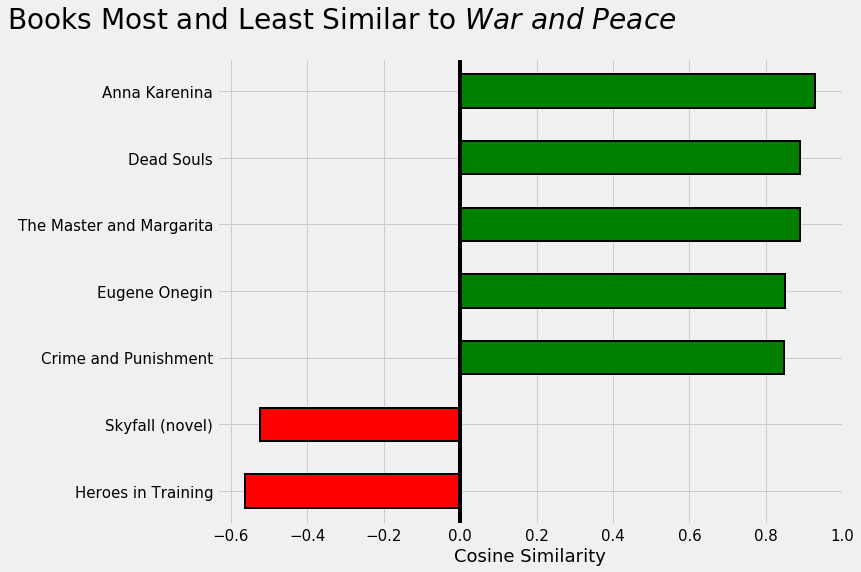

In [53]:
find_similar('War and Peace', book_weights, n = 5, plot = True)

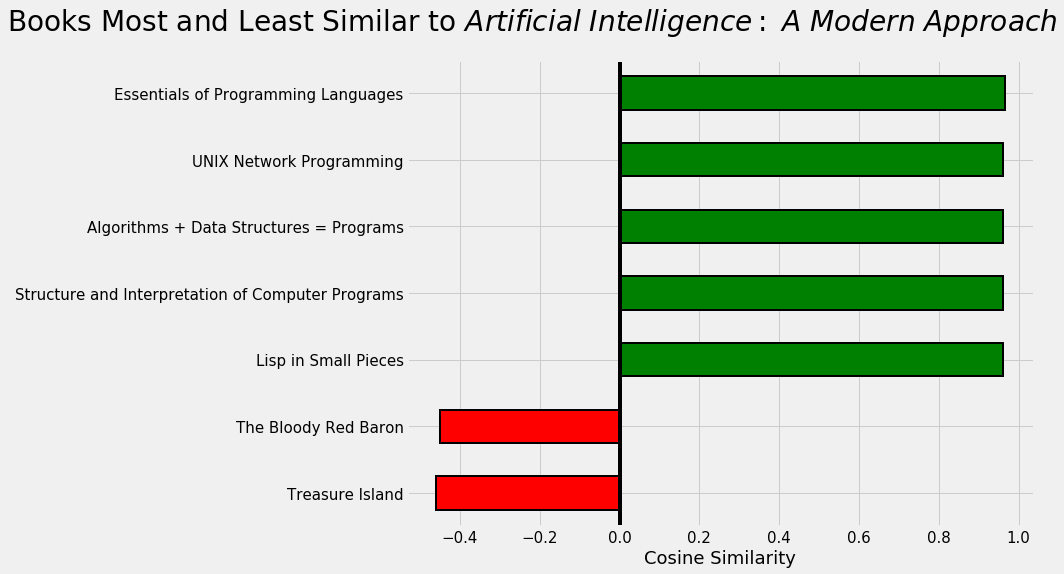

In [54]:
find_similar('Artificial Intelligence: A Modern Approach', book_weights, n = 5, plot = True)

## Wikilink Embeddings

We also have the embeddings of wikipedia links (which are themselves Wikipedia pages). We can take a similar approach to extract these and find the most similar to a query page.

Let's write a quick function to extract weights from a model given the name of the layer.

In [55]:
def extract_weights(name, model):
    """Extract weights from a neural network model"""
    
    # Extract weights
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    
    # Normalize
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

In [56]:
link_weights = extract_weights('link_embedding', model)

We can use the same find_similar function to find the most similar links to a given link.

In [57]:
find_similar('science fiction', link_weights, index_name = 'page')

Pages closest to science fiction.

Page: science fiction                            Similarity: 1.0
Page: category:american science fiction novels   Similarity: 0.93
Page: ballantine books                           Similarity: 0.92
Page: category:doubleday (publisher) books       Similarity: 0.9
Page: doubleday (publisher)                      Similarity: 0.9
Page: bantam books                               Similarity: 0.89
Page: category:time travel novels                Similarity: 0.87
Page: short story                                Similarity: 0.85
Page: united states                              Similarity: 0.85
Page: novella                                    Similarity: 0.83


In [58]:
find_similar('biography', link_weights, index_name = 'page')

Pages closest to biography.

Page: biography                             Similarity: 1.0
Page: autobiography                         Similarity: 0.9
Page: non-fiction                           Similarity: 0.9
Page: category:american non-fiction books   Similarity: 0.87
Page: category:english-language books       Similarity: 0.87
Page: memoir                                Similarity: 0.87
Page: category:1998 books                   Similarity: 0.86
Page: google books                          Similarity: 0.86
Page: new york times                        Similarity: 0.86
Page: the washington post                   Similarity: 0.85


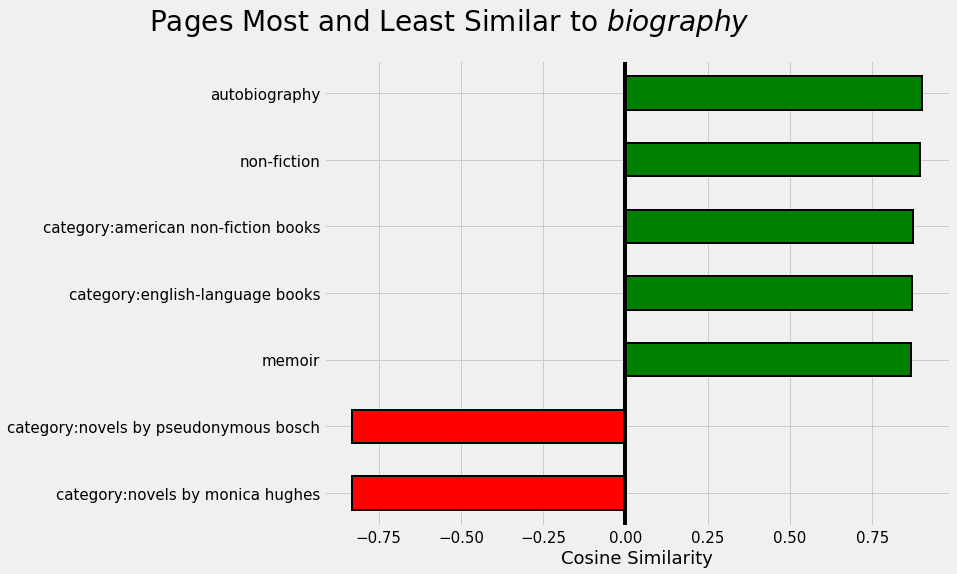

In [59]:
find_similar('biography', link_weights, index_name = 'page', n = 5, plot = True)

In [60]:
find_similar('new york city', link_weights, index_name = 'page', n = 5)

Pages closest to new york city.

Page: new york city                    Similarity: 1.0
Page: alfred a. knopf                  Similarity: 0.96
Page: the new york times               Similarity: 0.95
Page: random house                     Similarity: 0.94
Page: category:alfred a. knopf books   Similarity: 0.93


## Classification model

For the classification model, we are going to add an extra dense layer, we will sigmoid as the activation function and binary_crossentropy as the loss function which measures the error of the neural network predictions in a binary classification problem, and is a measure of the similarity between two distributions.

We train the model for 50 epochs and find that the classification model performs almost similar to the regression model

In [61]:
model_class = book_embedding_model(50, classification = True)
gen = generate_batch(pairs, n_positive, negative_ratio=2, classification = True)

In [62]:
# Train the model to learn embeddings
h = model_class.fit_generator(gen, epochs = 50, steps_per_epoch= len(pairs) // n_positive,
                            verbose = 1)

Epoch 1/50
754/754 [==============================] - 58s 78ms/step - loss: 0.6496 - acc: 0.6517
Epoch 2/50
754/754 [==============================] - 66s 87ms/step - loss: 0.5435 - acc: 0.7818
Epoch 3/50
754/754 [==============================] - 66s 88ms/step - loss: 0.4716 - acc: 0.8190
Epoch 4/50
754/754 [==============================] - 59s 79ms/step - loss: 0.4190 - acc: 0.8480
Epoch 5/50
754/754 [==============================] - 60s 80ms/step - loss: 0.4138 - acc: 0.8533
Epoch 6/50
754/754 [==============================] - 59s 79ms/step - loss: 0.3858 - acc: 0.8711
Epoch 7/50
754/754 [==============================] - 59s 78ms/step - loss: 0.3829 - acc: 0.8719
Epoch 8/50
754/754 [==============================] - 59s 78ms/step - loss: 0.3571 - acc: 0.8861
Epoch 9/50
754/754 [==============================] - 60s 79ms/step - loss: 0.3754 - acc: 0.8768
Epoch 10/50
754/754 [==============================] - 60s 79ms/step - loss: 0.3611 - acc: 0.8848
Epoch 11/50
754/754 [========

In [69]:
model_class.save('Embedding_classification.h5')

We'll go through the same process, extracting the weights and finding similar books based on the embedding space representation.

In [64]:
book_weights_class = extract_weights('book_embedding', model_class)
book_weights_class.shape

(37020, 50)

#### Looks like we're getting similar recommendations as we did for regression. The cosine similarity helps predict the recommendations

In [65]:
find_similar('War and Peace', book_weights_class, n = 5)

Books closest to War and Peace.

Book: War and Peace               Similarity: 1.0
Book: Anna Karenina               Similarity: 0.8
Book: The Master and Margarita    Similarity: 0.72
Book: Doctor Zhivago (novel)      Similarity: 0.69
Book: Demons (Dostoevsky novel)   Similarity: 0.67


In [66]:
find_similar('The Fellowship of the Ring', book_weights_class, n = 5)

Books closest to The Fellowship of the Ring.

Book: The Fellowship of the Ring   Similarity: 1.0
Book: The Two Towers               Similarity: 0.87
Book: The Return of the King       Similarity: 0.86
Book: The Fall of Gondolin         Similarity: 0.77
Book: The Children of Húrin        Similarity: 0.76


In [67]:
link_weights_class = extract_weights('link_embedding', model_class)

In [68]:
find_similar('the washington post', link_weights_class, index_name = 'page', n = 5)

Pages closest to the washington post.

Page: the washington post   Similarity: 1.0
Page: los angeles times     Similarity: 0.94
Page: the new york times    Similarity: 0.93
Page: time (magazine)       Similarity: 0.92
Page: new york times        Similarity: 0.91


## Visualizations

We will us TSNE (t-stochastic distributed Neighbor Embedding) to convert the 50 dimensional vectors into a 2 dimensional vector space. Therefore, we are taking the 37,000 dimensions in the case of books, embedding them to 50 dimensions with the neural network, and then embedding them down to 2 dimensions with a manifold.

In [75]:
def reduce_dim(weights, components = 3, method = 'tsne'):
    """Reduce dimensions of embeddings"""
    if method == 'tsne':
        return TSNE(components, metric = 'cosine').fit_transform(weights)
    elif method == 'umap':
        # Might want to try different parameters for UMAP
        return UMAP(n_components=components, metric = 'cosine', 
                    init = 'random', n_neighbors = 5).fit_transform(weights)

In [76]:
book_r = reduce_dim(book_weights_class, components = 2, method = 'tsne')
book_r.shape

(37020, 2)

In [77]:
info = list(chain(*[set(book[1]) for book in books]))
info_counts = count_items(info)
list(info_counts.items())[:10]

[('name', 36400),
 ('author', 35557),
 ('language', 32869),
 ('country', 30693),
 ('publisher', 30618),
 ('image', 28751),
 ('pages', 26090),
 ('media_type', 26016),
 ('genre', 25966),
 ('isbn', 24934)]

### We can group the embedding space by genre

In [78]:
genres = [book[1].get('genre', 'None').lower() for book in books]

# Remove genres not found
genre_counts = count_items(genres)
del genre_counts['none']
list(genre_counts.items())[:10]

[('science fiction', 2177),
 ('novel', 1641),
 ('non-fiction', 1270),
 ('fantasy', 974),
 ('fantasy novel', 780),
 ('historical novel', 582),
 ('science fiction novel', 571),
 ('fiction', 559),
 ('crime novel', 424),
 ("children's novel", 313)]

In [79]:
# Include 10 most popular genres
genre_to_include = list(genre_counts.keys())[:10]

In [80]:
idx_include = []
genres = []

for i, book in enumerate(books):
    if 'genre' in book[1].keys():
        if book[1]['genre'].lower() in genre_to_include:
            idx_include.append(i)
            genres.append(book[1]['genre'].capitalize())
            
len(idx_include)

9291

In [81]:
ints, gen = pd.factorize(genres)
gen[:5]

array(['Science fiction', 'Novel', 'Non-fiction', "Children's novel",
       'Fantasy'], dtype=object)

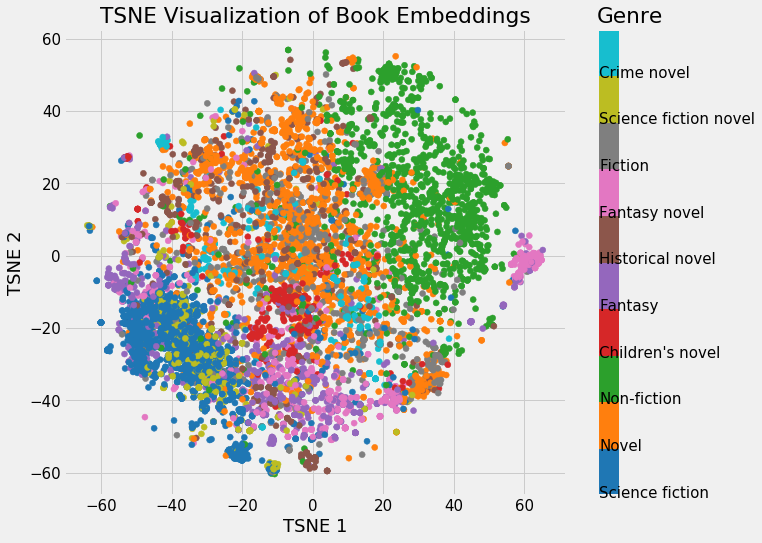

In [89]:
plt.figure(figsize = (10, 8))

# Plot embedding
plt.scatter(book_r[idx_include, 0], book_r[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(1, (18 * j + 1) / ((10) * 2), lab, ha='left', va='center')
cbar.ax.set_title('Genre', loc = 'left')


plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('TSNE Visualization of Book Embeddings');

#### Most Popular Books in Embedding

Let's see the embedding labeled with the 10 books most often mentioned by other books.

<Figure size 1008x864 with 0 Axes>

Text(1, 0.05, 'Science fiction')

Text(1, 1.05, 'Novel')

Text(1, 2.05, 'Non-fiction')

Text(1, 3.05, "Children's novel")

Text(1, 4.05, 'Fantasy')

Text(1, 5.05, 'Historical novel')

Text(1, 6.05, 'Fantasy novel')

Text(1, 7.05, 'Fiction')

Text(1, 8.05, 'Science fiction novel')

Text(1, 9.05, 'Crime novel')

Text(0.0, 1.0, 'Genre')

Text(0.5, 0, 'TSNE 1')

Text(0, 0.5, 'TSNE 2')

Text(0.5, 1.0, 'TSNE Visualization of Book Embeddings')

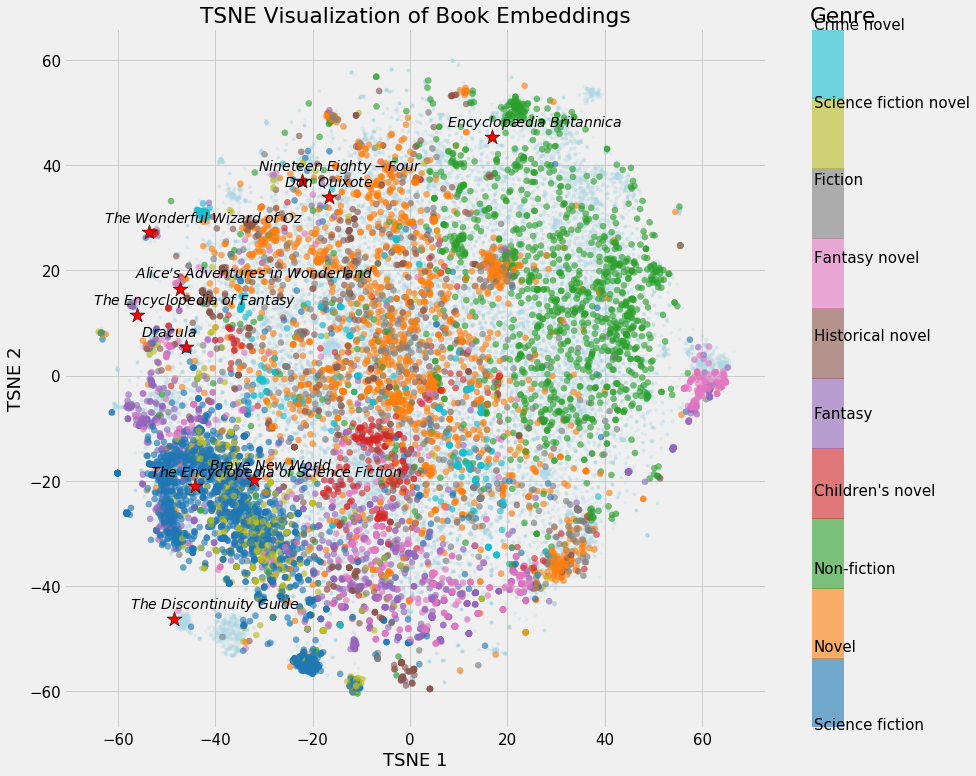

In [91]:
plt.figure(figsize = (14, 12))

# Plot all books
plt.scatter(book_r[:, 0], book_r[:, 1], marker = '.', color = 'lightblue', alpha = 0.2)

# Plot genres
plt.scatter(book_r[idx_include, 0], book_r[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10, alpha = 0.6)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(1, (20 * j + 1) / ((10) * 2), lab, ha='left', va='center')
    
cbar.ax.set_title('Genre', loc = 'left')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('TSNE Visualization of Book Embeddings');

for book in list(wikilink_book_counts.keys())[:10]:
    
    x, y = book_r[book_index[book], 0], book_r[book_index[book], 1];
    # Italize book title using latex
    s =  ''.join([' $\it{' + word + '}$' for word in book.split()])
    _ = plt.scatter(x, y, s = 250, color = 'r',
                    marker = '*', edgecolor = 'k')
    _ = plt.text(x - 10, y + 2, s, fontsize = 14);

## Conclusion

As we can clearly see from the results, we have successfully explored an efficient way to parse through wiki articles using multiprocessing  and process them in such a way to place similar articles close to one another. We explored Neural network embeddings to obtain the cosine similarity between the articles. We were successfully able to recommend articles similar to the query articles using classification and regression in Neural network embedding.
We can now extend the scope of the project beyond just books.


### Future work: 

My initial idea behind this project was to build a graph database for these articles and connect them through the wiki links that are present in the Wikipedia page. The article with the most common wiki links with the query article would be recommended. The idea was to build on this and on the concept of hierarchical clustering to obtain the most similar articles. Wikipedia also provides a clickstream dataset which provides the count of clicks on an article. We could use this with a combination of wiki dumps to provide most similar articles based on the query articles and also take into account the popularity of the article. .

## Citation

1. [Parsing wiki articles](https://towardsdatascience.com/wikipedia-data-science-working-with-the-worlds-largest-encyclopedia-c08efbac5f5c)
2. [Recommendation system for wiki articles](https://towardsdatascience.com/building-a-recommendation-system-using-neural-network-embeddings-1ef92e5c80c9)